# MuGloEst - 6ADCP experiment

### organizing the CT data... at every deploymnet we put 2 CTs, one at surface and one at the bottom

10/29/2025 - os dados dos ADCPs foram organizados e creio que estão bem... mas ainda não fechei os CTs, na questão da ordem dos dados!

In [1]:
# Rotina do Matlab "Muglo_campanha6adcps_sincroniza.m"

# Quadratura

# % Campanha 1, Estação 1 (N5, S-263, F-282)
# % Campanha 1, Estação 2 (N1, S-269, F-264)
# % Campanha 1, Estação 3 (N2, S-270, F-267)
# % Campanha 1, Estação 4 (N4, S-265, F-262)
# % Campanha 1, Estação 5 (N3, S-283, F-268)
# % Campanha 1, Estação 6 (N6, S-182, F-281)



In [2]:
import os
from dateutil.parser import parse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pickle

In [3]:
cts_path = r'd:\GUTO\1_Trabs\1_Aestus\Capibaribe\MuGloEst\201303_Campanha_6adcps\CTs_todos_CSV\\'
cts_files = os.listdir(cts_path)

In [4]:
# reduce the data averaging bursts
def data_redux(x):
    burst_length = 30
    n_bursts = len(x) // burst_length
    data_length = n_bursts * burst_length

    time = np.reshape(x[:data_length,0], (-1, 30))
    temperature = np.reshape(x[:data_length,1], (-1,30))
    salinity = np.reshape(x[:data_length,2], (-1, 30))

    time = time[:,0]
    temperature = np.mean(temperature, axis=1)
    salinity = np.mean(salinity, axis=1)

    data = np.column_stack((time, temperature, salinity))    
    return data

# separate the values from the files
def get_data(lines):    
    is_data = 0
    data = []
    for li in lines:
        if 'Date,Temp.[deg C],Sal.[ ],Cond.[mS/cm],EC 25[uS/cm],Batt.[V]' in li:
            is_data = 1
            continue
        if is_data == 1:
            liq = li.split(',')
            dt = parse(liq[0])
            temp = float(liq[1])
            sal = float(liq[2])
            data.append([dt, temp, sal])
    
    data = np.array(data)
    data = data_redux(data)
    return data
        
        

In [5]:
# testing the procedure

# with open(cts_path + '20130319_0700_ACTW-USB_0262_161437_A.csv') as io:
#     lines = io.readlines()

# is_data = 0
# data = []
# for li in lines:
#     if 'Date,Temp.[deg C],Sal.[ ],Cond.[mS/cm],EC 25[uS/cm],Batt.[V]' in li:
#         is_data = 1
#         continue
#     if is_data == 1:
#         liq = li.split(',')
#         dt = parse(liq[0])
#         temp = float(liq[1])
#         sal = float(liq[2])
#         data.append([dt, temp, sal])

# data = np.array(data)

# data.shape

In [6]:
# da onde saiu isto?
# do Roteiro de rotinas de Processamento MuGlo campanhas 6 ADCPs
# ROTEIRO_Muglo_Processamento_Dados_Campanha6ADCPS.txt

# se não me engano, as estruturas de fundeio não foram desmontadas entre uma campanha e outra,
# desta forma, os conjuntos são vãlios para as duas campanhas

# a ordem que está abaixo coincide com a ordem de instalação da 2.a campanha (sizígia)

# CTs
#         Superf      Fundo
    #1 -   #263        #282		praticage
	#2 -   #269        #264		polícia federal	
	#3 -   #270        #267		bombeiros
	#4 -   #265        #262		hospital
	#5 -   #283        #268		rampa sport
	#6 -   #182        #281		Joana Bezerra

# conjuntos, não necessariamente na ordem de instalação ou recuperaçao
cts_1 = ['263', '282']
cts_2 = ['269', '264']
cts_3 = ['270', '267']
cts_4 = ['265', '262']
cts_5 = ['283', '268']
cts_6 = ['182', '281']
cts = [cts_1, cts_2, cts_3, cts_4, cts_5, cts_6]

day_neap = '20130319'
day_spri = '20130326'
campaign_days = [day_neap, day_spri]


In [7]:
campaigns = ['neap', 'spring']
stations = ['a', 'b', 'c', 'd', 'e', 'f']
levels = ['surface', 'bottom']

# creating a nested empty dictionary to be populated in the for loop
data = {
        campaign:
             {
              station:
                      {
                       level: {} for level in levels
                      }
              for station in stations
             }  
        for campaign in campaigns
        }

In [8]:
for f in cts_files:
    if f.endswith('csv'):

        # load and reduces the data
        with open(cts_path + f) as io:
            lines = io.readlines()
        x = get_data(lines)   #[time, temperature, salinity]
        x = x[x[:,2] > 1, :]  # elimitate the data out of water considering the salinity values

        # populate the dictionary, with reduced data
        for j, day in enumerate(campaign_days):

            if day in f:

                for i, station in enumerate(stations):

                    if any(sn in f for sn in cts[i]):

                        level = 'surface' if cts[i][0] in f else 'bottom'  # chatgpt

                        data[campaigns[j]][station][level] = x


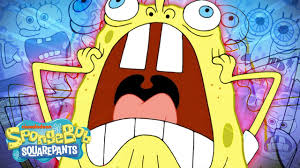  
Data organization hell...
1) The moorings sets were the same in both campaigns - ADCP/CT_botton/CT_surface
2) There is the annotations of the CTs set, which was at bottom and which was at surface
3) We know the order of installation of the moorings
4) We build da dictionary with 3 layers CAMPAING - STATION - LEVEL
5) We initially names the setes from 'a' to 'f'
6) Based on the time, se renamed the stations acording the instalation order

In [9]:
# rename_map = {'old_key1': 'new_key1', 'old_key2': 'new_key2'}

# for old, new in rename_map.items():
#     if old in data:
#         data[new] = data.pop(old)

stations_names = ['Praticagem', 'PF', 'Hospital', 'Rampa', 'Bombeiros', 'JoanaBezerra']

rename_map_neap = {'a': 'Praticagem', 'b': 'Hospital', 'c':'Bombeiros', 'd': 'PF', 'e':'Rampa', 'f':'JoanaBezerra'}
rename_map_spring =  {'a': 'Praticagem', 'b': 'PF', 'c':'Bombeiros', 'd': 'Hospital', 'e':'Rampa', 'f':'JoanaBezerra'}

for old, new in rename_map_neap.items():
    if old in data['neap']:
        data['neap'][new] = data['neap'].pop(old)
        
for old, new in rename_map_spring.items():
    if old in data['spring']:
        data['spring'][new] = data['spring'].pop(old)


In [73]:
for d in data:
    print(data[d].keys())

dict_keys(['Praticagem', 'Hospital', 'Bombeiros', 'PF', 'Rampa', 'JoanaBezerra'])
dict_keys(['Praticagem', 'PF', 'Bombeiros', 'Hospital', 'Rampa', 'JoanaBezerra'])


2013-03-26 05:20:00
2013-03-26 05:30:00
2013-03-26 06:20:00
2013-03-26 06:30:00
2013-03-26 06:00:00
2013-03-26 06:40:00


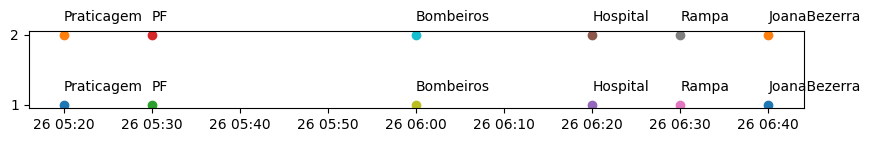

In [74]:
# SPRING

plt.figure(figsize=(10,1))
for station in stations_names:
    xs = data['spring'][station]['surface']
    xf = data['spring'][station]['bottom']
    print(xf[0,0])
    plt.plot(xs[0,0], 1, 'o')
    plt.plot(xf[0,0], 2, 'o')
    plt.text(xs[0,0], 1.2, station)
    plt.text(xf[0,0], 2.2, station)

2013-03-20 05:40:00
2013-03-20 06:00:00
2013-03-20 07:00:00
2013-03-20 07:00:00
2013-03-20 07:20:00
2013-03-20 06:30:00


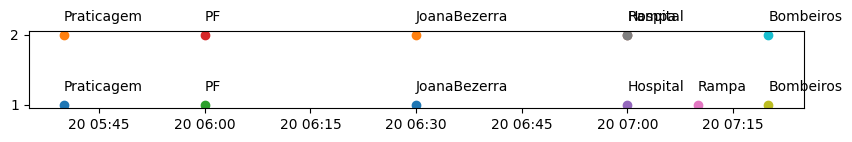

In [65]:
# NEAP

plt.figure(figsize=(10,1))
for station in stations_names:
    xs = data['neap'][station]['surface']
    xf = data['neap'][station]['bottom']
    print(xf[0,0])
    plt.plot(xs[0,0], 1, 'o')
    plt.plot(xf[0,0], 2, 'o')
    plt.text(xs[0,0], 1.2, station)
    plt.text(xf[0,0], 2.2, station)

In [76]:
with open('Dic_CTs.pkl', 'wb') as io:
    pickle.dump(data, io)

In [75]:
Do Matlab!


Roteiro de rotinas de Processamento MuGlo campanhas 6 ADCPs

======================================
>>Muglo_campanha6adcps_processa_adcp.m
======================================

Esta rotina carrega os dados, seleciona o período de fundeio identificado pela pressão,
e salva os dados num .MAT (sen v1 v2 amp) utilizando a nomenclatura

Dados_Ci_Ej.mat    i=[1 2] {campanha}   j=[1 2 3 4 5 6] {estação}

conteúdo: sen v1 v2 amp

#1 - praticagem (marco zero)
#2 - polícia federal
#3 - bombeiros 
#4 - hospital
#5 - rampa Sport
#6 - Joana Bezerra

============================
>>Muglo_campanha6adcps_CTs.m
============================

Rotina para reduzir os dados dos CTs fundeados junto com os ADCPs. Carrega o .CSV
e faz a média dos bursts. Salva utilizando a nomenclatura

Ci_CT_snXXX.mat    i=[1 2] {campanha} XXX: número de série do CT

conteúdo: Dados_CT [ano mes dia hora min temperatura sal] 


=============================================
>>Muglo_campanha6adcps_sincroniza_Campanha1.m  ou 2
=============================================
onde i=[1 2] {campanha}

Rotinas para sincronizar os dados de ADCPs com CTs para cada estação

Cara rotina tem 6 blocos (para cada estação) onde
1 - carrega dados 'Dados_Ci_Ej.mat' de ADCP
2 - carrega dados dos CTs em função do número de série como abaixo
	     Superfície    Fundo
	#1 -   #263        #282		praticage
	#2 -   #269        #264		polícia federal	
	#3 -   #270        #267		bombeiros
	#4 -   #265        #262		hospital
	#5 -   #283        #268		rampa sport
	#6 -   #182        #281		Joana Bezerra
3 - define um tempo de dias e décimos de dias pelo ADCP
4 - interpola os dados dos CTs para o tempo do ADCP
5 - salva em 

Dados_Ci_Ej_tudo.mat

conteúdo: tempo sen v1 v2 amp tempS salS tempF salF 

=====================================
>>Muglo_analisa_classificao_HRCiEj.m
=====================================
onde i=[1 2] {campanha}   j=[1 2 3 4 5 6] {estação}

Série de rotinas para analisar individualmente cada estação de cada campanha.

1 - carrega Dados_Ci_Ej_tudo.mat
2 - seleciona período de tempo (25 horas) para fazer análise
3 - seleciona dados do ADCP válidos (ATENÇÂO para achar camada de topo)
	rotina Nortek_inserenanas
4 - determina as componentes longitudinal e transversal das correntes
	ENCHENTE - NEGATIVO - 
	VAZANTE - POSITIVO

===============================
>> Muglo_campanha6adcps_C1_mare
===============================

Compara a maré nas 6 estações nas duas campanhas (apesar do nome)

========================================
>>Muglo_campanha6adcps_achaareadassecoes
========================================

Acha a área das seções transversais com base na largura (GoogleEarth), 
na profundidade média de sizígia, e considerando as seções trapezoidais
com talude de 45 graus


SyntaxError: invalid syntax (1604359268.py, line 1)